# Introduction-Data-Science Task 3

Lena Breitberg, Doreen Mack, David Riethmann

---

# Setup

## Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn._config import set_config
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from lazypredict.Supervised import LazyRegressor

import helpers
set_config(transform_output="pandas")
%matplotlib inline

### Load Data

In [2]:
test_data = pd.read_csv('../data/BikeRentalDaily_test.csv', sep=';', index_col='instant')
train_data = pd.read_csv('../data/BikeRentalDaily_train.csv', sep=';', index_col='instant')

## Pipeline

In [3]:
datetime_converter = helpers.DatetimeConverter(target_column='dteday', date_format='%d.%m.%Y')

In [4]:
test_data = datetime_converter.transform(test_data)
train_data = datetime_converter.transform(train_data)

Das sind die finalen Schritte des Preprocessing aus Taks 2.

In [5]:
season_imputer = helpers.SeasonImputer(target_column='season', date_column='dteday')
correct_weekday = helpers.WeekdayMapper(target_column='weekday', date_column='dteday')
windspeed_mean_imputer = helpers.ThresholdImputer(target_column='windspeed', threshold=0.0)
column_name_transformer = FunctionTransformer(helpers.clean_column_names)
weekend_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0', 'weekday_6']})
weekday_group = helpers.GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']})

In [6]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday']),
    (OneHotEncoder(sparse_output=False, drop='first', dtype=int), ['weathersit']),
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['hum']),
    (StandardScaler(), ['atemp', 'windspeed', 'leaflets']),
    ('drop', ['temp', 'workingday', 'mnth', 'dteday','cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [7]:
preprocessing_pipeline = make_pipeline(
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group
)

### Remove Outlier

In [8]:
outlier_remover = helpers.OutlierRemover(target='cnt', threshold=3.0)

In [9]:
test_data_no = outlier_remover.fit_transform(test_data)
train_data_no = outlier_remover.fit_transform(train_data)

131 rows remaining after removing outliers.
596 rows remaining after removing outliers.


## Split Data

In [10]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, train_data['cnt'], test_size=0.2, random_state=42)

In [11]:
X_train_no, X_validate_no, y_train_no, y_validate_no = train_test_split(train_data_no, train_data_no['cnt'], test_size=0.2, random_state=42)

## Performance Measures

### Helpers

In [12]:
def plot_comparative_bar_charts(df, metrics):
    num_metrics = len(metrics)
    # Adjust for single metric to ensure axs is always a list
    if num_metrics == 1:
        fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6))
        axs = [axs]  # Make it a list to keep indexing consistent
    else:
        fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6))

    for i, metric in enumerate(metrics):
        df.plot(kind='bar', y=metric, ax=axs[i], legend=False)
        axs[i].set_title(metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('Models')

    plt.tight_layout()
    plt.show()
    
# Metrics to compare
metrics = ["R2"]
data = {}

In [13]:
def plot_feature_importance(reg, X_test, y_test, X_train):
    feature_importance = reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(X_train.columns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

### Funktionen

In [14]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures



In [15]:
def actualVsPredictChart(true_v, pred_v, model: str = ""):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title(f"{model} Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

# 1 Baseline Model

### Pipeline

In [16]:
baseline = make_pipeline(
    preprocessing_pipeline,
    LinearRegression()
)

### Evaluation

In [17]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('seasonimputer',
                                  SeasonImputer(date_column='dteday',
                                                target_column='season')),
                                 ('weekdaymapper',
                                  WeekdayMapper(date_column='dteday',
                                                target_column='weekday')),
                                 ('thresholdimputer',
                                  ThresholdImputer(target_column='windspeed')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehote...
                                  FunctionTransformer(func=<function clean_column_names at 0x7fa13f8b31a0>)),
                                 ('grouponehotencodedtransformer-1',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                                           'weekday_6']})),
                                 ('grouponehotencodedtransformer-2',
                                  GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                                           'weekday_2',
                                                                                           'weekday_3',
                                                                                           'weekday_4',
                                                                                           'weekday_5']}))])),
                ('linearregression', LinearRegression())])

In [18]:
y_pred = baseline.predict(X_validate)

In [19]:
measures = performance_measures(y_validate, y_pred, len(baseline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.11
MAE: 1263.70
RMSE: 4160.70


In [20]:
data["Baseline"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

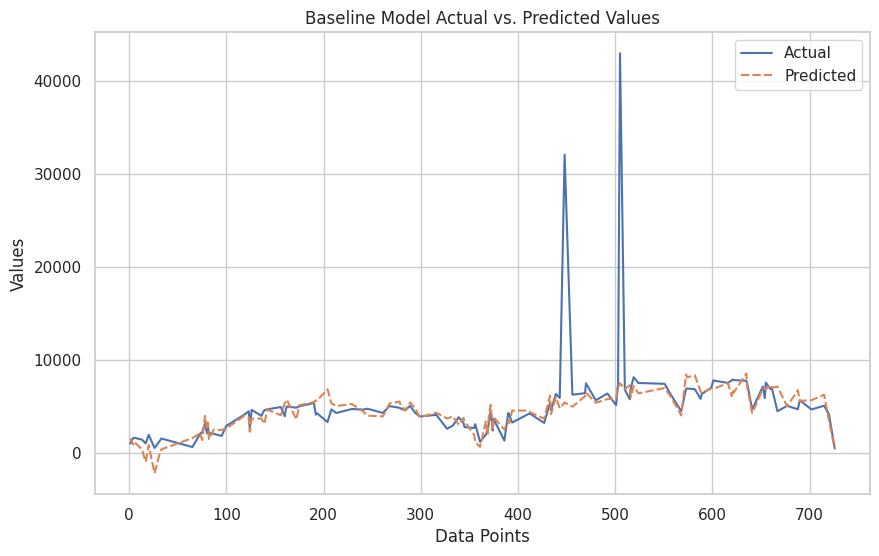

In [21]:
actualVsPredictChart(y_validate, y_pred, "Baseline Model")

# 2 Initial Model Selection

## Helpers

In [22]:
def visualize_lazy_predictions(models, predictions, y_validate, n_predictors: int):
    """
    Visualize the predictions from the lazy regressor

    Args:
        predictions: dict, predictions from the lazy regressor
    """
    models = models.sort_values(by='R-Squared', ascending=False)
    for model_name in models.iloc[: 3].index:
        y_pred = predictions[model_name].to_list()
        _ = performance_measures(y_validate, y_pred, n_predictors)
        actualVsPredictChart(y_validate, y_pred, model_name)

Für die Evaluierung verschiedener Algorithmen nutzen wir die Bibliothek Lazy Predict bzw. aus dieser Bibliothek den Lazy Regressor. Diese wurde von Shankar Rao Pandala entwickelt. Es handelt sich um eine Wrapper-Bibliothek, die auf vielen verschiedenen Machine Learning Bibliotheken und -Algorithmen basiert.
Der Lazy Regressor automatisiert den Auswahlprozess geeigneter Regressionsmodelle, indem eine Vielzahl von Modellen auf den vorliegenden Datensatz angewandt wird. Dieser wird zuvor durch minimales Preprocessing für den Auswahlprozess vorbereitet z.B. mittels Scaling und Imputation. 
Im Anschluss werden die Modelle anhand der gängigen Metriken, in unserem Fall R-Squared und MAE bewertet. Es ist wichtig zu beachten, dass kein automatisiertes Hyperparamter Tuning durchgeführt wird.
Dieses Vorgehen bietet vor allem den Vorteil, dass des gesamte Prozess automatisiert abläuft und die Bibliothek sehr einfach anzuwenden ist. Zusätzlich wird eine erhebliche Zeitersparnis ermöglicht.

## With Outlier

In [23]:
X_train = preprocessing_pipeline.fit_transform(X_train)
X_validate = preprocessing_pipeline.fit_transform(X_validate)

In [24]:
lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = lazy_regressor.fit(X_train, X_validate, y_train, y_validate)

100%|██████████| 42/42 [00:02<00:00, 18.57it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 13
[LightGBM] [Info] Start training from score 4632.100000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In diesem DataFrame sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der Typ `GradientBoostingRegressor` nach allen Metriken den höchsten Wert für Adjusted R-Squared erzielt. Weitere gut abschneidende Modelltypen sind der `XGBRegressor` und der `ExtraTreesRegressor`. Für das Parametertuning werden alle drei Typen näher betrachtet, da es sein könnte, dass eines der drei Modelle deutlich besser abschneidet, sobald die Hyperparameter angepasst werden. Den Modelltyp `HistGradientBoostingRegressor` werden wir nicht verwenden, da dieser besonders ähnliche Eigenschaften aufweist, wie der `GradientBoostingRegressor`.

In [25]:
models.head()

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,0.14,0.25,4074.24,0.03
LGBMRegressor,0.14,0.25,4085.99,0.04
HuberRegressor,0.14,0.24,4093.27,0.01
PassiveAggressiveRegressor,0.13,0.24,4097.85,0.01
HistGradientBoostingRegressor,0.12,0.23,4119.30,0.11


Auf dieser Grafik ist ein Vergleich zwischen tatsächlichen und vorhergesagten Daten des `GradientBoostingRegressor` zu sehen. Es ist zu erkennen, dass es einige Ausreißer nach unten gibt, die das Modell nicht abbilden konnte. Bei dem Wert am rechten Ende des Graphen konnte das Modell dies jedoch sehr gut.

R2: 0.25
Adjusted R2: 0.14
MAE: 1082.56
RMSE: 4074.24


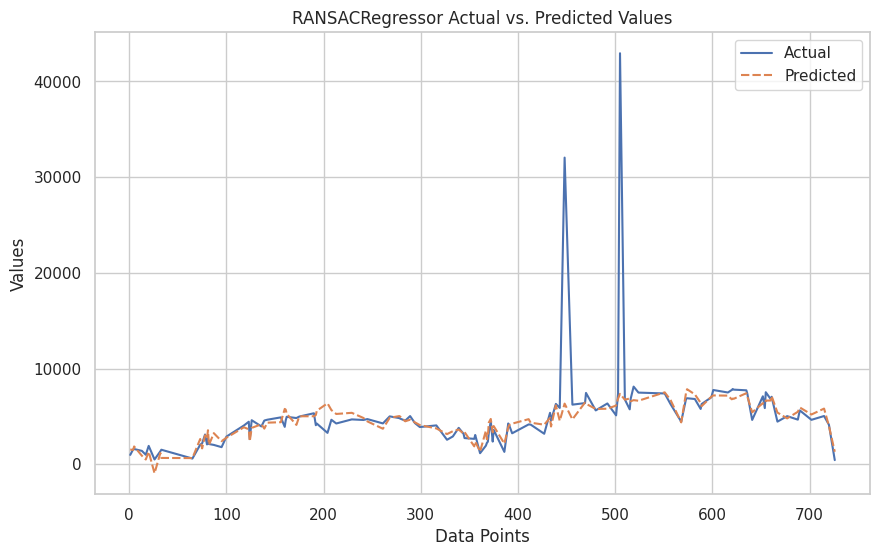

R2: 0.25
Adjusted R2: 0.14
MAE: 1179.18
RMSE: 4085.99


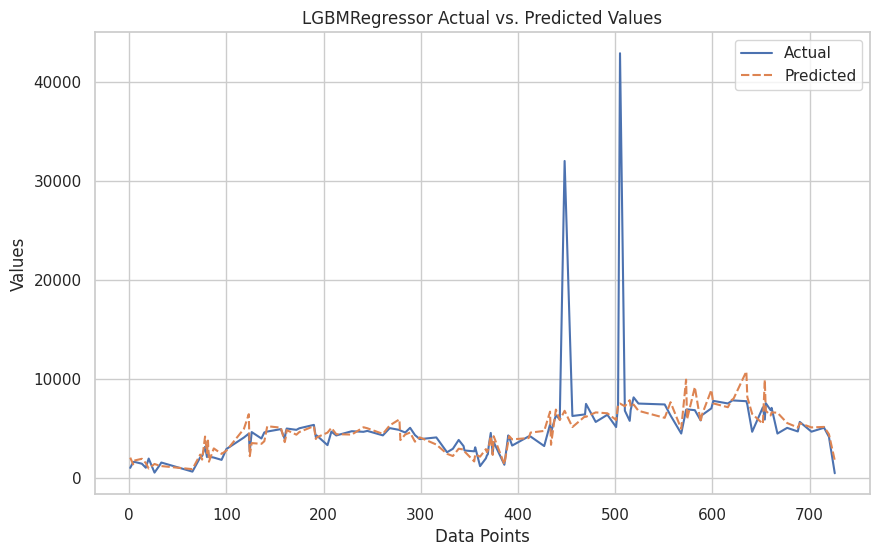

R2: 0.24
Adjusted R2: 0.14
MAE: 1087.04
RMSE: 4093.27


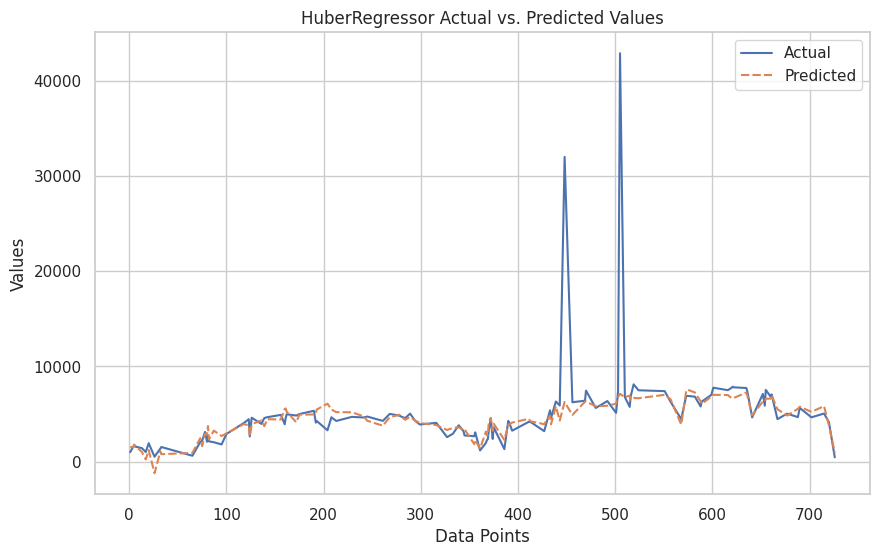

In [26]:
visualize_lazy_predictions(models, predictions, y_validate, X_train.shape[1])

## Without Outlier

In [27]:
X_train_no = preprocessing_pipeline.fit_transform(X_train_no)
X_validate_no = preprocessing_pipeline.fit_transform(X_validate_no)

In [28]:
lazy_regressor_no = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models_no, predictions_no = lazy_regressor_no.fit(X_train_no, X_validate_no, y_train_no, y_validate_no)

100%|██████████| 42/42 [00:08<00:00,  5.19it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 13
[LightGBM] [Info] Start training from score 4459.361345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [29]:
models_no.head()

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.85,0.87,673.34,0.11
PassiveAggressiveRegressor,0.84,0.86,697.25,0.01
HuberRegressor,0.84,0.86,699.40,0.01
LassoLarsIC,0.83,0.85,714.16,0.01
LarsCV,0.83,0.85,715.21,0.07


R2: 0.87
Adjusted R2: 0.85
MAE: 533.52
RMSE: 673.34


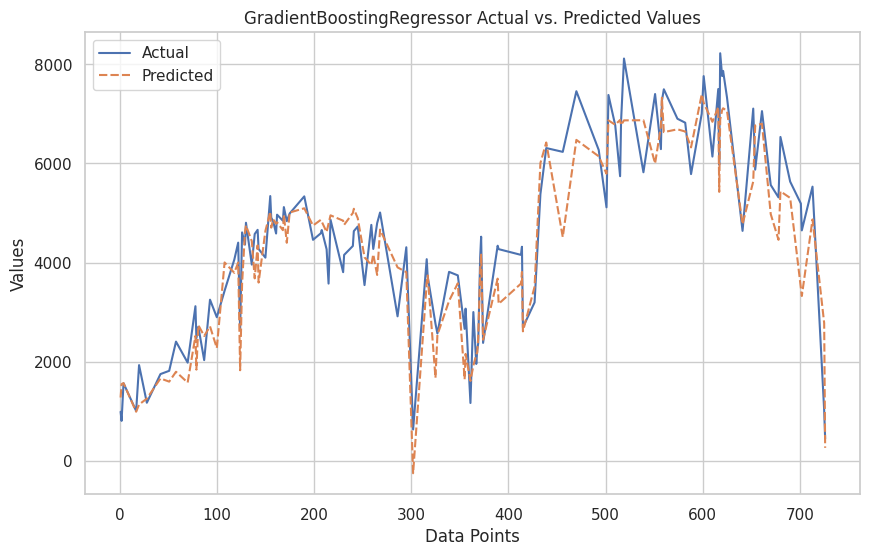

R2: 0.86
Adjusted R2: 0.84
MAE: 567.72
RMSE: 697.25


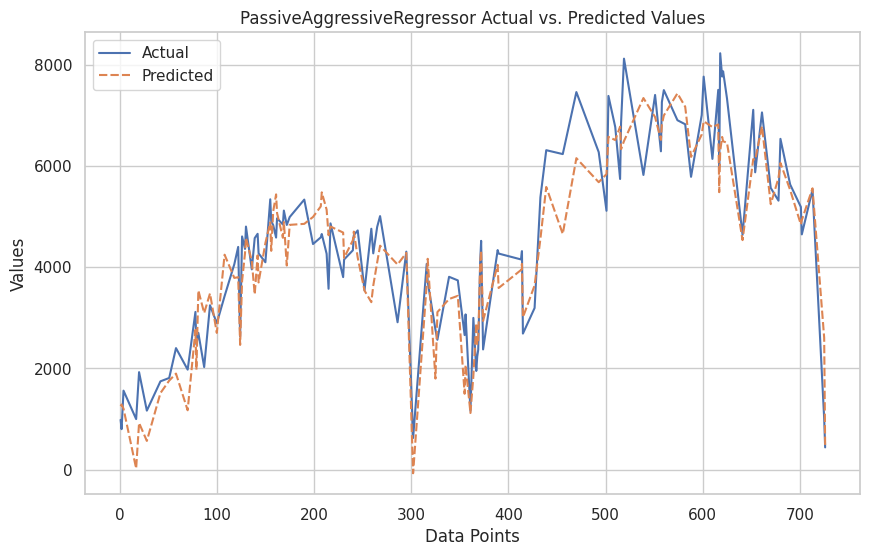

R2: 0.86
Adjusted R2: 0.84
MAE: 562.53
RMSE: 699.40


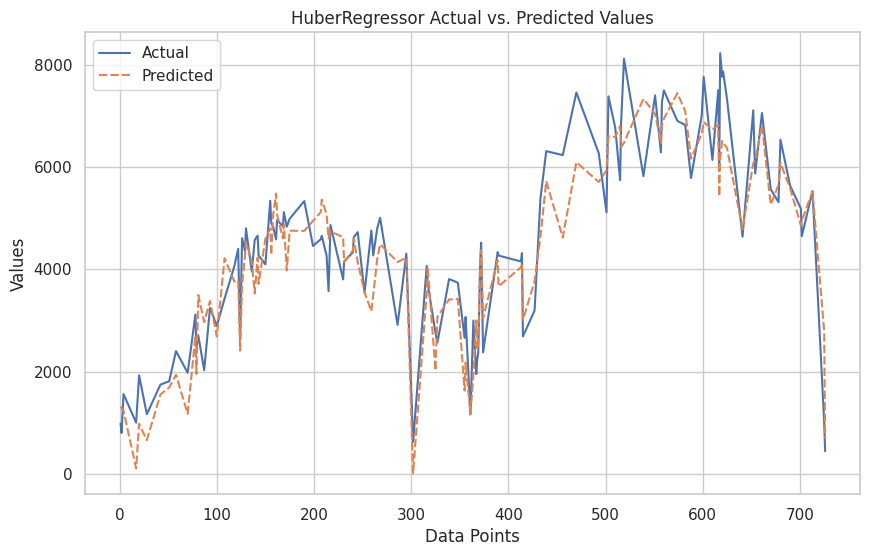

In [30]:
visualize_lazy_predictions(models_no, predictions_no, y_validate_no, X_train_no.shape[1])

# 3 Hyperparamter Tuning

Im Folgenden probieren wir verschiedene Kombinationen von Hyperparametern für die drei ausgewählten Algorithmen aus, um jeweils die beste Leistung des Modells zu erzielen.

## With Outliers

### RANSACRegressor

#### Grid Search

In [31]:
base_estimator = LinearRegression()
ransac_regressor = RANSACRegressor(estimator=base_estimator, random_state=42)

In [32]:
param_grid = {
    'ransacregressor__min_samples': [0.5, 0.6, 0.7],  # Proportion of total samples or absolute number
    'ransacregressor__max_trials': [50, 100, 150],  # Maximum number of iterations for random sample selection.
    'ransacregressor__stop_probability': [0.99, 0.999],  # Confidence level of the algorithm to terminate iterations
    'ransacregressor__loss': ['absolute_error', 'squared_error'],  # Loss function to be used
}

pipeline = make_pipeline(
    preprocessing_pipeline,
    ransac_regressor
)

In [33]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [34]:
grid_search.fit(train_data, train_data['cnt'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('seasonimputer',
                                                         SeasonImputer(date_column='dteday',
                                                                       target_column='season')),
                                                        ('weekdaymapper',
                                                         WeekdayMapper(date_column='dteday',
                                                                       target_column='weekday')),
                                                        ('thresholdimputer',
                                                         ThresholdImputer(target_column='windspeed')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthro...
                                                                                                                  'weekday_4',
                                                                                                                  'weekday_5']}))])),
                                       ('ransacregressor',
                                        RANSACRegressor(estimator=LinearRegression(),
                                                        random_state=42))]),
             n_jobs=-1,
             param_grid={'ransacregressor__loss': ['absolute_error',
                                                   'squared_error'],
                         'ransacregressor__max_trials': [50, 100, 150],
                         'ransacregressor__min_samples': [0.5, 0.6, 0.7],
                         'ransacregressor__stop_probability': [0.99, 0.999]},
             scoring='r2', verbose=1)

In [35]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'ransacregressor__loss': 'absolute_error', 'ransacregressor__max_trials': 50, 'ransacregressor__min_samples': 0.6, 'ransacregressor__stop_probability': 0.99}
Best score: 0.477305094453537


#### Validation

In [36]:
ransac_regressor = RANSACRegressor(estimator=LinearRegression(), loss='absolute_error', max_trials=50, min_samples=0.6, stop_probability=0.99, random_state=42)

In [37]:
ransac_regressor.fit(X_train, y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=50, min_samples=0.6,
                random_state=42)

In [38]:
y_pred = ransac_regressor.predict(X_validate)

In [39]:
measures = performance_measures(y_validate, y_pred, len(ransac_regressor.estimator_.coef_))

R2: 0.25
Adjusted R2: 0.14
MAE: 1083.86
RMSE: 4086.36


In [40]:
data["GridSearch_RANSAC"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### HuberRegressor

#### Grid Search

In [41]:
huber_regressor = HuberRegressor()

In [42]:
param_grid = {
    'huberregressor__epsilon': [1.1, 1.2, 1.3],  # Epsilon parameter for the Huber loss
    'huberregressor__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'huberregressor__max_iter': [100, 200, 300],  # Maximum number of iterations
}

pipeline = make_pipeline(
    preprocessing_pipeline,
    huber_regressor
)

In [43]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [44]:
grid_search.fit(train_data, train_data['cnt'])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('seasonimputer',
                                                         SeasonImputer(date_column='dteday',
                                                                       target_column='season')),
                                                        ('weekdaymapper',
                                                         WeekdayMapper(date_column='dteday',
                                                                       target_column='weekday')),
                                                        ('thresholdimputer',
                                                         ThresholdImputer(target_column='windspeed')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthro...
                                                        ('grouponehotencodedtransformer-2',
                                                         GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                                                                  'weekday_2',
                                                                                                                  'weekday_3',
                                                                                                                  'weekday_4',
                                                                                                                  'weekday_5']}))])),
                                       ('huberregressor', HuberRegressor())]),
             n_jobs=-1,
             param_grid={'huberregressor__alpha': [0.0001, 0.001, 0.01],
                         'huberregressor__epsilon': [1.1, 1.2, 1.3],
                         'huberregressor__max_iter': [100, 200, 300]},
             scoring='r2', verbose=1)

In [45]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'huberregressor__alpha': 0.0001, 'huberregressor__epsilon': 1.3, 'huberregressor__max_iter': 100}
Best score: 0.4755513656846594


#### Validation

In [46]:
huber_regressor = HuberRegressor(alpha=0.0001, epsilon=1.3, max_iter=100)

In [47]:
huber_regressor.fit(X_train, y_train)

HuberRegressor(epsilon=1.3)

In [48]:
y_pred = huber_regressor.predict(X_validate)

In [49]:
measures = performance_measures(y_validate, y_pred, len(huber_regressor.coef_))

R2: 0.24
Adjusted R2: 0.14
MAE: 1087.03
RMSE: 4093.09


In [50]:
data["GridSearch_Huber"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

## Without Outliers

### GradientBoostingRegressor

#### Grid Search

In [51]:
gradient_boosting_regressor = GradientBoostingRegressor(random_state=42)

In [52]:
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],  # Number of boosting stages
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'gradientboostingregressor__max_depth': [3, 4, 5],  # Maximum depth of the individual estimators
    'gradientboostingregressor__min_samples_split': [2, 3, 4],  # Minimum number of samples required to split an internal node
}

pipeline = make_pipeline(
    preprocessing_pipeline,
    gradient_boosting_regressor
)

In [53]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [54]:
grid_search.fit(train_data_no, train_data_no['cnt'])

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('seasonimputer',
                                                         SeasonImputer(date_column='dteday',
                                                                       target_column='season')),
                                                        ('weekdaymapper',
                                                         WeekdayMapper(date_column='dteday',
                                                                       target_column='weekday')),
                                                        ('thresholdimputer',
                                                         ThresholdImputer(target_column='windspeed')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthro...
                                                                                                                  'weekday_5']}))])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__learning_rate': [0.01, 0.1,
                                                                      0.2],
                         'gradientboostingregressor__max_depth': [3, 4, 5],
                         'gradientboostingregressor__min_samples_split': [2, 3,
                                                                          4],
                         'gradientboostingregressor__n_estimators': [100, 200,
                                                                     300]},
             scoring='r2', verbose=1)

In [55]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 100}
Best score: 0.8614966252761193


#### Validation

In [56]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100, random_state=42)

In [57]:
gradient_boosting_regressor.fit(X_train_no, y_train_no)

GradientBoostingRegressor(learning_rate=0.2, random_state=42)

In [58]:
y_pred = gradient_boosting_regressor.predict(X_validate_no)

In [59]:
measures = performance_measures(y_validate_no, y_pred, len(gradient_boosting_regressor.feature_importances_))

R2: 0.86
Adjusted R2: 0.84
MAE: 557.85
RMSE: 699.13


In [60]:
data["GridSearch_Gradient_Boosting_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### Passive Aggressive Regressor

#### Grid Search

In [61]:
passive_aggressive_regressor = PassiveAggressiveRegressor(random_state=42)

In [62]:
param_grid = {
    'passiveaggressiveregressor__C': [0.01, 0.1, 1, 10],
    'passiveaggressiveregressor__max_iter': [1000, 1500, 2000],
    'passiveaggressiveregressor__tol': [1e-3, 1e-4],
    'passiveaggressiveregressor__early_stopping': [True, False],
}

pipeline = make_pipeline(
    preprocessing_pipeline,
    passive_aggressive_regressor
)

In [63]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [64]:
grid_search.fit(train_data_no, train_data_no['cnt'])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/davidrmn/anaconda3/envs/introduction-data-science/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/davidrmn/anaconda3/envs/introduction-data-science/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/davidrmn/anaconda3/envs/introduction-data-science/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/davidrmn/anaconda3/envs/introduction-data-science/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum nu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('seasonimputer',
                                                         SeasonImputer(date_column='dteday',
                                                                       target_column='season')),
                                                        ('weekdaymapper',
                                                         WeekdayMapper(date_column='dteday',
                                                                       target_column='weekday')),
                                                        ('thresholdimputer',
                                                         ThresholdImputer(target_column='windspeed')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthro...
                                                                                                                  'weekday_5']}))])),
                                       ('passiveaggressiveregressor',
                                        PassiveAggressiveRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'passiveaggressiveregressor__C': [0.01, 0.1, 1, 10],
                         'passiveaggressiveregressor__early_stopping': [True,
                                                                        False],
                         'passiveaggressiveregressor__max_iter': [1000, 1500,
                                                                  2000],
                         'passiveaggressiveregressor__tol': [0.001, 0.0001]},
             scoring='r2', verbose=1)

In [65]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'passiveaggressiveregressor__C': 10, 'passiveaggressiveregressor__early_stopping': False, 'passiveaggressiveregressor__max_iter': 1000, 'passiveaggressiveregressor__tol': 0.001}
Best score: 0.812989150298101


#### Validation

In [66]:
passive_aggressive_regressor = PassiveAggressiveRegressor(C=10, early_stopping=False, max_iter=1000, tol=0.001, random_state=42)

In [67]:
passive_aggressive_regressor.fit(X_train_no, y_train_no)

PassiveAggressiveRegressor(C=10, random_state=42)

In [68]:
y_pred = passive_aggressive_regressor.predict(X_validate_no)

In [69]:
measures = performance_measures(y_validate_no, y_pred, len(passive_aggressive_regressor.coef_))

R2: 0.85
Adjusted R2: 0.83
MAE: 571.70
RMSE: 708.72


In [70]:
data["GridSearch_Passive_Aggressive_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### HuberRegressor

#### GridSearch

In [71]:
huber_regressor_no = HuberRegressor()

In [72]:
param_grid = {
    'huberregressor__epsilon': [1.1, 1.2, 1.3],  # Epsilon parameter for the Huber loss
    'huberregressor__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'huberregressor__max_iter': [100, 200, 300],  # Maximum number of iterations
}

pipeline = make_pipeline(
    preprocessing_pipeline,
    huber_regressor_no
)

In [73]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [74]:
grid_search.fit(train_data_no, train_data_no['cnt'])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('seasonimputer',
                                                         SeasonImputer(date_column='dteday',
                                                                       target_column='season')),
                                                        ('weekdaymapper',
                                                         WeekdayMapper(date_column='dteday',
                                                                       target_column='weekday')),
                                                        ('thresholdimputer',
                                                         ThresholdImputer(target_column='windspeed')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthro...
                                                        ('grouponehotencodedtransformer-2',
                                                         GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                                                                  'weekday_2',
                                                                                                                  'weekday_3',
                                                                                                                  'weekday_4',
                                                                                                                  'weekday_5']}))])),
                                       ('huberregressor', HuberRegressor())]),
             n_jobs=-1,
             param_grid={'huberregressor__alpha': [0.0001, 0.001, 0.01],
                         'huberregressor__epsilon': [1.1, 1.2, 1.3],
                         'huberregressor__max_iter': [100, 200, 300]},
             scoring='r2', verbose=1)

In [75]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'huberregressor__alpha': 0.0001, 'huberregressor__epsilon': 1.3, 'huberregressor__max_iter': 100}
Best score: 0.8181077531792604


#### Validation

In [76]:
huber_regressor_no = HuberRegressor(alpha=0.0001, epsilon=1.3, max_iter=100)

In [77]:
huber_regressor_no.fit(X_train_no, y_train_no)

HuberRegressor(epsilon=1.3)

In [78]:
y_pred = huber_regressor_no.predict(X_validate_no)

In [79]:
measures = performance_measures(y_validate_no, y_pred, len(huber_regressor_no.coef_))

R2: 0.86
Adjusted R2: 0.84
MAE: 561.87
RMSE: 698.43


In [80]:
data["GridSearch_Huber_NO"] = {'R2': measures['R2'], 'MAE': measures['MAE']}

### 3.1 GradientBoostingRegressor

- **Loss**: Loss bezeichnet das Verlustmaß. Dieses soll minimiert werden. Wir verwenden die Methode "quantile" d.h. die Quantilregression. Hierdurch wird der quantile Fehler minimiert, was zu robusteren Regressionen führen kann. Desweiteren stehen die Methoden squared_error (Minimierung des mittleren quadratischer Fehlers zwischen vorhergesagten und tatsächlichen Werten), absolute_error (Minimierung des mittleren absoluten Fehlers zwischen vorhergesagten und tatsächlichen Werten) sowie huber (Kombination aus quadratischem und absolutem Fehler) zur Auswahl.
- **Alpha**: Der Alpha-Wert beeinflusst die Gewichtung der Residuals in der Quantilregression. Durch die Variation von alpha kann der Fokus auf unterschiedliche Quantile gelegt werden. Wir verwenden eine Liste von Werten von 0.2 bis 0.8 in Schritten von 0.2.
- **Criterion**: Hiermit ist das Kriterium gemeint, das zur Auswahl der besten Aufteilung in jedem Entscheidungsbaumknoten verwendet wird. In diesem Fall werden 'friedman_mse' und 'squared_error' verwendet. 'friedman_mse' ist eine verbesserte Version des mittleren quadratischen Fehlers (MSE) für Gradient Boosting.
- **Learning Rate**: Die Lernrate steuert, wie stark jeder Baum die vorherigen Bäume korrigiert. Eine niedrige Lernrate erfordert im Normalfall mehr Bäume, um den gleichen Effekt zu erzielen, kann jedoch im Gegenzug zu einer besseren Generalisierung führen. Hier werden Werte von 0.1 bis 0.5 in Schritten von 0.1 verwendet.
- **Max Depth**: Max Depth meint die maximale Tiefe eines einzelnen Entscheidungsbaums. Eine tiefere Baumstruktur kann zu Overfitting führen, während eine flachere Struktur zu Underfitting führen kann. Wir verwenden hier die Werte None, 5 und 10. None bedeutet, dass es keine festgelegte maximale Tiefe gibt.
- **Number of Estimators**: Hier wird die Anzahl der Bäume (Schätzer) im Ensemble festgelegt. Eine höhere Anzahl von Bäumen kann zu einer besseren Modellleistung führen, erfordert jedoch mehr Rechenressourcen. Wir legen die Werte 50, 100 und 200 zur Auswahl fest.

# 4 Feature Selection

    Rank 1: This rank is assigned to features that the RFECV process considers the most important or relevant for predicting the target variable. These features are retained until the last iteration of the elimination process. Essentially, features with a rank of 1 are the ones that the RFECV identifies as important and selects to keep in the model.

    Higher Ranks (greater than 1): These ranks are assigned to features based on the order in which they are eliminated during the recursive feature elimination process. A feature with a rank of 2 is the one that is eliminated just before the process ends (just after all rank 1 features are decided). Similarly, a feature with a rank of 3 is eliminated one step before the rank 2 features, and so on. The higher the rank, the earlier the feature was eliminated in the RFECV process, indicating it is less important or less relevant for predicting the target variable according to the model used in RFECV.

## Helpers

In [81]:
def plot_rfecv_feature_ranking(feature_names, ranking, selected_features_mask):
    """
    Plot the feature ranking as determined by RFECV.

    Parameters:
    - feature_names: list of strings, names of the features.
    - ranking: array-like, the ranking of the features returned by RFECV.
    - selected_features_mask: array-like, boolean mask indicating selected features by RFECV.
    """
    feature_names = [f"Feature {i}" for i in X_train_no.columns]
    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(feature_names))
    plt.barh(y_pos, ranking, color='skyblue', align='center')
    plt.yticks(y_pos, feature_names)
    plt.gca().invert_yaxis()  # Invert y axis to have the highest rank on top
    plt.xlabel('Ranking (1 = selected)')
    plt.title('Feature Ranking by RFECV')

    # Highlight selected features
    selected_features = np.array(feature_names)[selected_features_mask]
    for feature in selected_features:
        plt.barh(np.where(np.array(feature_names) == feature)[0], 1, color='green', align='center')

    plt.show()

## With Outliers

### RANSAC Regressor

#### Feature Backward Elimination

In [82]:
recursive_feature_elimination = RFECV(ransac_regressor.estimator_, step=1, cv=5, scoring='r2')
recursive_feature_elimination.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), scoring='r2')

In [83]:
recursive_feature_elimination.n_features_

7

In [84]:
recursive_feature_elimination.support_

array([ True,  True,  True,  True, False,  True, False,  True, False,
       False,  True, False, False, False, False])

#### Validation

In [85]:
selected_features = X_train.columns[recursive_feature_elimination.support_]
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]

In [86]:
ransac_regressor.fit(X_train_selected, y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=50, min_samples=0.6,
                random_state=42)

In [87]:
y_pred = ransac_regressor.predict(X_validate_selected)

In [88]:
measures = performance_measures(y_validate, y_pred, len(ransac_regressor.estimator_.coef_))

R2: 0.23
Adjusted R2: 0.18
MAE: 1140.11
RMSE: 4137.82


In [89]:
recursive_feature_elimination.score(X_validate, y_validate)

0.22187090153910927

In [90]:
data["RFECV_RANSAC"] = {'R2': recursive_feature_elimination.score(X_validate, y_validate)}

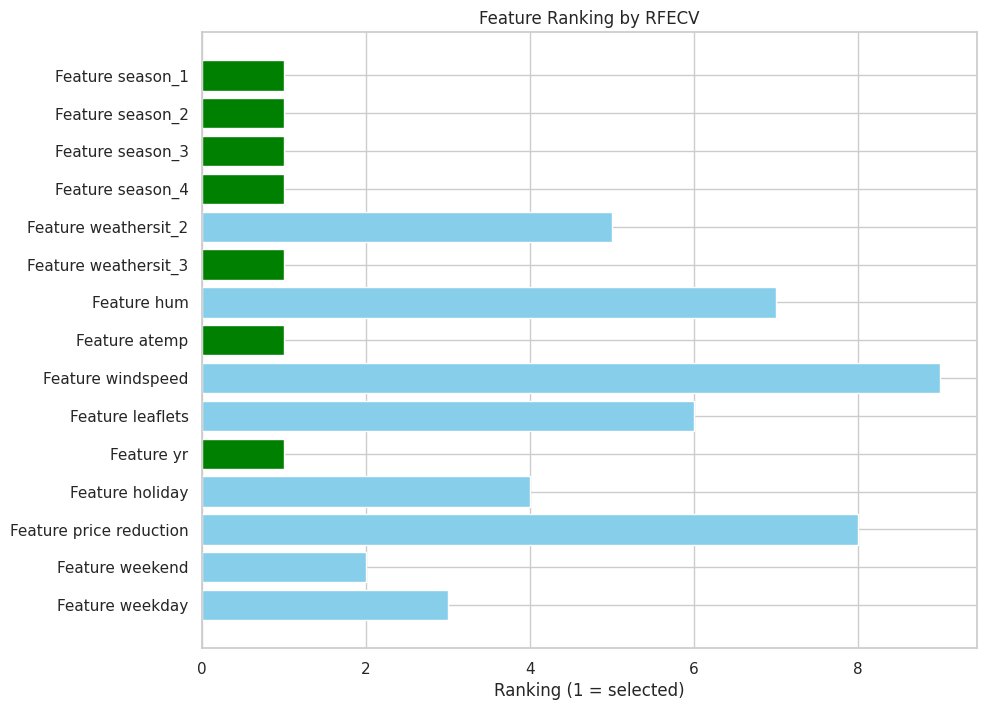

In [91]:
plot_rfecv_feature_ranking(X_train.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

### Huber Regressor

#### Feature Backward Elimination

In [92]:
recursive_feature_elimination = RFECV(huber_regressor, step=1, cv=5, scoring='r2')
recursive_feature_elimination.fit(X_train, y_train)

RFECV(cv=5, estimator=HuberRegressor(epsilon=1.3), scoring='r2')

In [93]:
recursive_feature_elimination.n_features_

10

#### Validation

In [94]:
selected_features = X_train.columns[recursive_feature_elimination.support_]
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]

In [95]:
huber_regressor.fit(X_train_selected, y_train)

HuberRegressor(epsilon=1.3)

In [96]:
y_pred = huber_regressor.predict(X_validate_selected)

In [97]:
measures = performance_measures(y_validate, y_pred, len(huber_regressor.coef_))

R2: 0.24
Adjusted R2: 0.18
MAE: 1086.15
RMSE: 4092.44


In [98]:
recursive_feature_elimination.score(X_validate, y_validate)

0.244858057262325

In [99]:
data["RFECV_HUBER"] = {'R2': recursive_feature_elimination.score(X_validate, y_validate)}

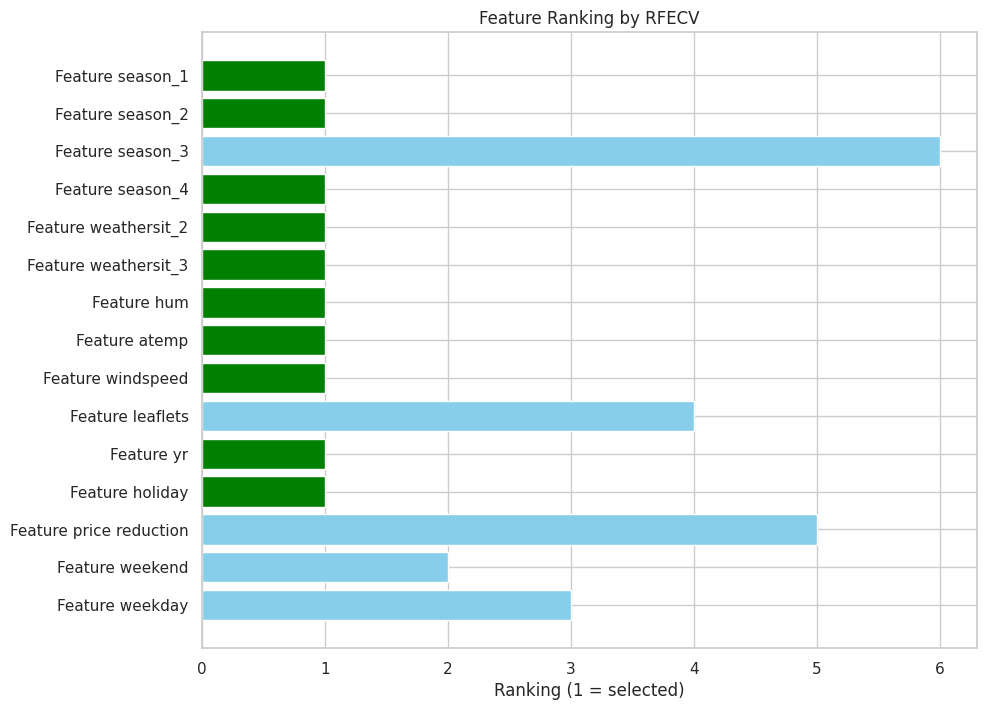

In [100]:
plot_rfecv_feature_ranking(X_train.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

## Without Outliers

### Gradient Boost Regressor

#### Feature Backward Elimination

In [101]:
recursive_feature_elimination = RFECV(gradient_boosting_regressor, step=1, cv=5, n_jobs=-1)
recursive_feature_elimination.fit(X_train_no, y_train_no)

RFECV(cv=5,
      estimator=GradientBoostingRegressor(learning_rate=0.2, random_state=42),
      n_jobs=-1)

In [102]:
recursive_feature_elimination.n_features_

15

#### Validation

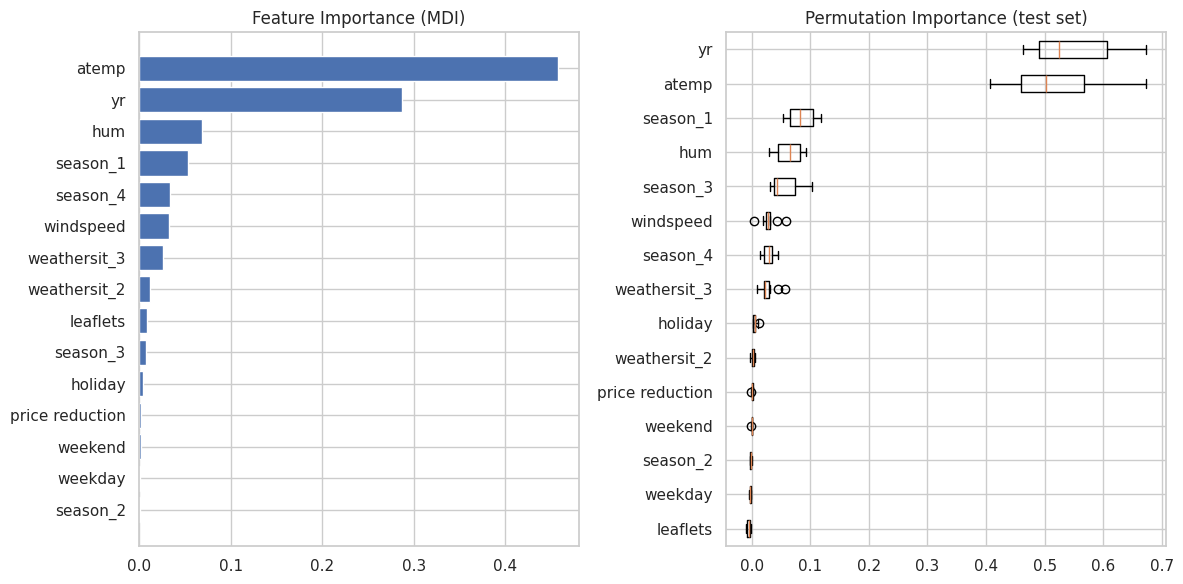

In [103]:
plot_feature_importance(gradient_boosting_regressor, X_validate_no, y_validate_no, X_train_no)

In [104]:
selected_features = X_train_no.columns[recursive_feature_elimination.support_]
X_train_selected = X_train_no[selected_features]
X_validate_selected = X_validate_no[selected_features]

In [105]:
#gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.2, max_depth=3, min_samples_split=2, n_estimators=100, random_state=42)

In [106]:
gradient_boosting_regressor.fit(X_train_selected, y_train_no)

GradientBoostingRegressor(learning_rate=0.2, random_state=42)

In [107]:
y_pred = gradient_boosting_regressor.predict(X_validate_selected)

In [108]:
measures = performance_measures(y_validate_no, y_pred, len(gradient_boosting_regressor.feature_importances_))

R2: 0.86
Adjusted R2: 0.84
MAE: 557.85
RMSE: 699.13


In [109]:
recursive_feature_elimination.score(X_validate_no, y_validate_no)

0.8588167261757673

In [110]:
data["RFECV_Gradient_Boosting_NO"] = {'R2': recursive_feature_elimination.score(X_validate_no, y_validate_no)}

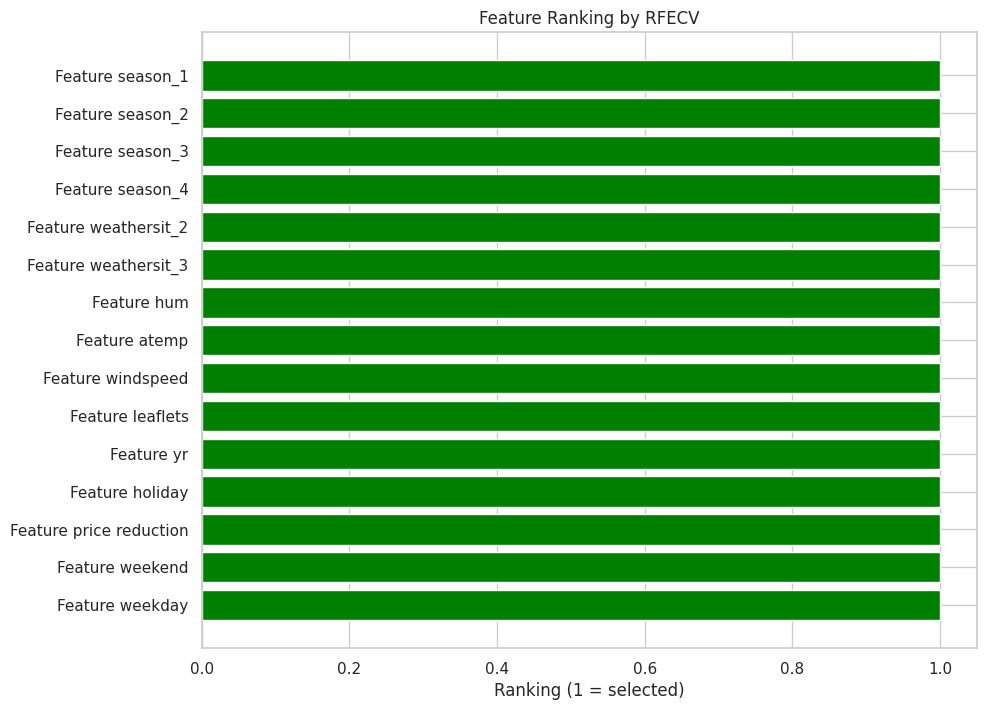

In [111]:
plot_rfecv_feature_ranking(X_train_no.columns, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

### Passive Aggressive Regressor

#### Feature Backward Elimination

In [112]:
recursive_feature_elimination = RFECV(passive_aggressive_regressor, step=1, cv=5, n_jobs=-1)
recursive_feature_elimination.fit(X_train_no, y_train_no)

RFECV(cv=5, estimator=PassiveAggressiveRegressor(C=10, random_state=42),
      n_jobs=-1)

In [113]:
recursive_feature_elimination.n_features_

13

#### Validation

In [114]:
selected_features = X_train_no.columns[recursive_feature_elimination.support_]
X_train_selected = X_train_no[selected_features]
X_validate_selected = X_validate_no[selected_features]

In [115]:
passive_aggressive_regressor = PassiveAggressiveRegressor(C=10, early_stopping=False, max_iter=1000, tol=0.001, random_state=42)

In [116]:
passive_aggressive_regressor.fit(X_train_selected, y_train_no)

PassiveAggressiveRegressor(C=10, random_state=42)

In [117]:
y_pred = passive_aggressive_regressor.predict(X_validate_selected)

In [118]:
measures = performance_measures(y_validate_no, y_pred, len(passive_aggressive_regressor.coef_))

R2: 0.86
Adjusted R2: 0.84
MAE: 569.55
RMSE: 698.90


R2: 0.86
Adjusted R2: 0.84
MAE: 573.99
RMSE: 704.56

In [119]:
recursive_feature_elimination.score(X_validate_no, y_validate_no)

0.8589089878536118

In [120]:
data["RFECV_Passive_Aggressive_NO"] = {'R2': recursive_feature_elimination.score(X_validate_no, y_validate_no)}

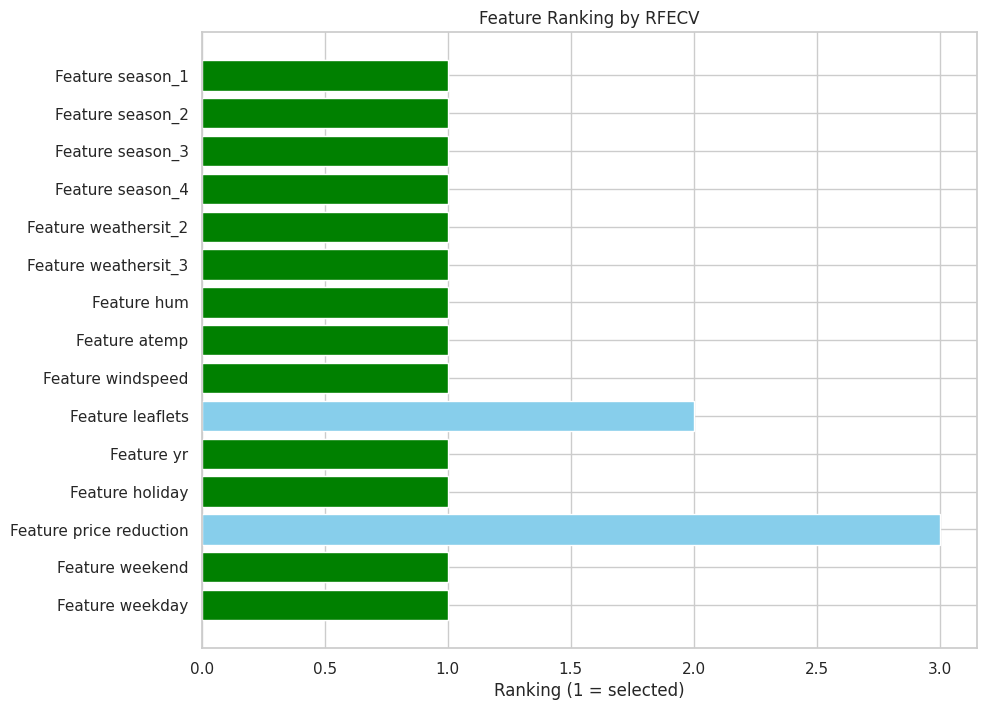

In [121]:
plot_rfecv_feature_ranking(X_train_no, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

### Huber Regressor

#### Feature Backward Elimination

In [122]:
recursive_feature_elimination = RFECV(huber_regressor_no, step=1, cv=5, n_jobs=-1)
recursive_feature_elimination.fit(X_train_no, y_train_no)

RFECV(cv=5, estimator=HuberRegressor(epsilon=1.3), n_jobs=-1)

In [123]:
recursive_feature_elimination.n_features_

12

#### Validation

In [124]:
recursive_feature_elimination.score(X_validate_no, y_validate_no)

0.859624196052935

In [125]:
data["RFECV_Huber_NO"] = {'R2': recursive_feature_elimination.score(X_validate_no, y_validate_no)}

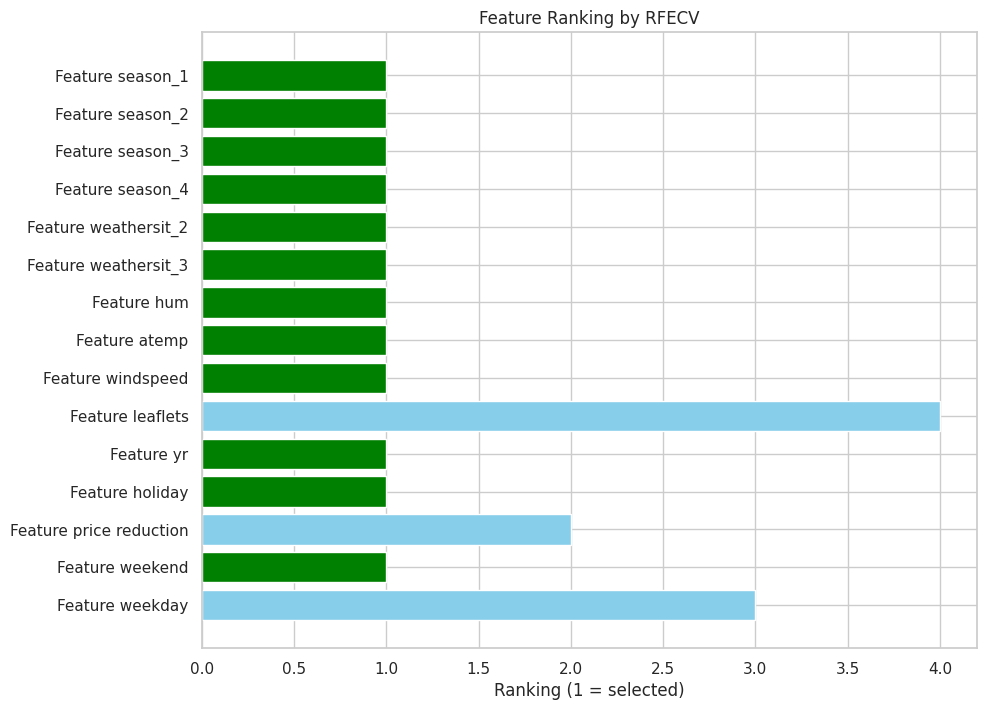

In [126]:
plot_rfecv_feature_ranking(X_train_no, recursive_feature_elimination.ranking_, recursive_feature_elimination.support_)

# 5 Final Model

In [127]:
df = pd.DataFrame(data).T
df

,R2,MAE
Baseline,0.22,1263.70
GridSearch_RANSAC,0.25,1083.86
GridSearch_Huber,0.24,1087.03
GridSearch_Gradient_Boosting_NO,0.86,557.85
GridSearch_Passive_Aggressive_NO,0.85,571.70
GridSearch_Huber_NO,0.86,561.87
RFECV_RANSAC,0.22,NaN
RFECV_HUBER,0.24,NaN
RFECV_Gradient_Boosting_NO,0.86,NaN
RFECV_Passive_Aggressive_NO,0.86,NaN


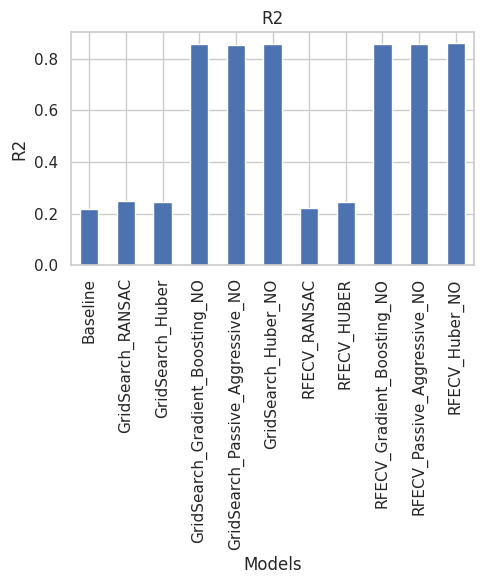

In [128]:
plot_comparative_bar_charts(df, metrics)